# Программирование на Python, БИ

## НИУ ВШЭ, 2025-26 учебный год

## Проект

### Часть 1

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, norm, levene, ttest_ind
from sklearn.utils import resample
from statsmodels.api import qqplot

In [ ]:
df = pd.read_csv('data_ab.csv')
df

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2025-01-03 22:28:38.630509,control,old_page,0
294474,945152,2025-01-12 00:51:57.078372,control,old_page,0
294475,734608,2025-01-22 11:45:03.439544,control,old_page,0
294476,697314,2025-01-15 01:20:28.957438,control,old_page,0


In [ ]:
df['timestamp'] = df['timestamp'].apply(lambda x: x.split()[0])
df['timestamp'] = pd.to_datetime(df['timestamp'])
df

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21,control,old_page,0
1,804228,2025-01-12,control,old_page,0
2,661590,2025-01-11,treatment,new_page,0
3,853541,2025-01-08,treatment,new_page,0
4,864975,2025-01-21,control,old_page,1
...,...,...,...,...,...
294473,751197,2025-01-03,control,old_page,0
294474,945152,2025-01-12,control,old_page,0
294475,734608,2025-01-22,control,old_page,0
294476,697314,2025-01-15,control,old_page,0


In [ ]:
print(f"Полные дубликаты: {df.duplicated().sum()}")
print(f"Проверка на nan: {df.isna().sum().sum()}")

Полные дубликаты: 0
Проверка на nan: 0


На первый взгяд сразу заметно, что соответствие ***control - old_page*** и ***treatment - new_page*** нарушено. Поэтому поменяем значения групп на правильные исходя из той страницы, которую увидел юзер.

In [ ]:
df.loc[df['landing_page'] == 'old_page', 'group'] = 'control'
df.loc[df['landing_page'] == 'new_page', 'group'] = 'treatment'

In [ ]:
print(f"Полные дубликаты: {df.duplicated().sum()}")

Полные дубликаты: 60


Но пока не будем их удалять. Посмотрим, может быть на самом деле дубликатов больше.

In [ ]:
duplicated_user_id = df[df[['user_id', 'group', 'landing_page', 'converted']].duplicated(keep=False) == True]
duplicated_user_id.sort_values('user_id')

,user_id,timestamp,group,landing_page,converted
255753,630320,2025-01-12,control,old_page,0
207211,630320,2025-01-07,control,old_page,0
39852,630805,2025-01-22,control,old_page,0
73599,630805,2025-01-12,control,old_page,0
213377,630871,2025-01-08,control,old_page,0
...,...,...,...,...,...
32034,945369,2025-01-24,control,old_page,0
183169,945387,2025-01-03,treatment,new_page,0
275158,945387,2025-01-20,treatment,new_page,0
243428,945627,2025-01-17,treatment,new_page,1


Как видим дубликатов на самом деле сильно больше. Единственное что у нас отличается - время. Но а так как это дубликаты, то они могут повлиять на искажение A/B тестирования - удалим их.

In [ ]:
df = df.drop_duplicates(subset=['user_id', 'group', 'landing_page', 'converted'])
df

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21,control,old_page,0
1,804228,2025-01-12,control,old_page,0
2,661590,2025-01-11,treatment,new_page,0
3,853541,2025-01-08,treatment,new_page,0
4,864975,2025-01-21,control,old_page,1
...,...,...,...,...,...
294473,751197,2025-01-03,control,old_page,0
294474,945152,2025-01-12,control,old_page,0
294475,734608,2025-01-22,control,old_page,0
294476,697314,2025-01-15,control,old_page,0


Отлично. Мы избавились от "почти полных" дубликатов. Посмотрим, вдруг еще остались строки, где один и тот же человек поставил разную оценку на одну и ту же страницу.

In [ ]:
duplicated_user_id = df[df[['user_id', 'group', 'landing_page']].duplicated(keep=False) == True]
duplicated_user_id.sort_values('user_id')

,user_id,timestamp,group,landing_page,converted
38021,632592,2025-01-18,treatment,new_page,0
116055,632592,2025-01-08,treatment,new_page,1
260527,632690,2025-01-04,control,old_page,1
26803,632690,2025-01-22,control,old_page,0
73265,633243,2025-01-13,treatment,new_page,0
...,...,...,...,...,...
7574,943016,2025-01-23,control,old_page,0
245895,944152,2025-01-21,control,old_page,1
100222,944152,2025-01-12,control,old_page,0
243703,944533,2025-01-20,treatment,new_page,0


Как видим, такие строки есть. Почему так вышло? Есть предположение, что эти юзеры просто спустя время поменяли свое мнение на счет оценки страницы. Но с точки зрения A/B тестов это невозможно, поскольку иначе нарушается независимость. (Независимость оценок - ключевое требования для A/B тестов). Поэтому будем брать первую оценку из двух(которые в дубликатах пользователей). Первую смотрим по ***timestamp***.

In [ ]:
df_to_del = duplicated_user_id.sort_values(['user_id', 'timestamp']).iloc[1::2, :]
clean_df = pd.concat([df, df_to_del]).drop_duplicates(keep=False)
clean_df

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21,control,old_page,0
1,804228,2025-01-12,control,old_page,0
2,661590,2025-01-11,treatment,new_page,0
3,853541,2025-01-08,treatment,new_page,0
4,864975,2025-01-21,control,old_page,1
...,...,...,...,...,...
294473,751197,2025-01-03,control,old_page,0
294474,945152,2025-01-12,control,old_page,0
294475,734608,2025-01-22,control,old_page,0
294476,697314,2025-01-15,control,old_page,0


In [ ]:
duplicated = clean_df[clean_df[['user_id', 'group']].duplicated(keep=False) == True]
duplicated

,user_id,timestamp,group,landing_page,converted


Отлично, больше нет такого, что один и тот же юзер воутит два раза в одной и той же группе. Посмотрим в целом, остались ли еще не уникальные user_id в нашем дата сете.

In [ ]:
non_unique_user_ids = df[df[['user_id']].duplicated(keep='first') == True]
print(f"Кол-во уникальных пользователей: {len(np.unique(clean_df['user_id']))}")
print(f"Кол-во пользователей, которые присутствуют в обоих группах эксперимента: {len(non_unique_user_ids)}")
print(f"Процентное соотношение: {len(non_unique_user_ids) / len(np.unique(clean_df['user_id'])) * 100}%")
duplicated_user_id = df[df[['user_id']].duplicated(keep=False) == True]
duplicated_user_id.sort_values('user_id')

Кол-во уникальных пользователей: 290584
Кол-во пользователей, которые присутствуют в обоих группах эксперимента: 2412
Процентное соотношение: 0.8300525837623545%


,user_id,timestamp,group,landing_page,converted
230259,630052,2025-01-17,treatment,new_page,0
213114,630052,2025-01-07,control,old_page,1
251762,630126,2025-01-19,treatment,new_page,0
22513,630126,2025-01-14,control,old_page,0
183371,630137,2025-01-20,control,old_page,0
...,...,...,...,...,...
99479,945703,2025-01-18,control,old_page,0
40370,945797,2025-01-11,treatment,new_page,1
186960,945797,2025-01-13,control,old_page,0
165143,945971,2025-01-16,control,old_page,0


Такие пользователи есть. Дропнем их точно также(берем только первое встречающееся значение по времени, первое вхождение), поскольку если юзер увидел сначала одну страницу, оценил ее, а затем увидел вторую и также оценил, то его вторая оценка уже зависит от оценки первой страницы. Тогда нарушается ключевой критерий A/B тестрования - независимость.

In [ ]:
df_to_del = duplicated_user_id.sort_values(['user_id', 'timestamp']).iloc[1::2, :]
clean_df = pd.concat([df, df_to_del]).drop_duplicates(keep=False)
clean_df

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21,control,old_page,0
1,804228,2025-01-12,control,old_page,0
2,661590,2025-01-11,treatment,new_page,0
3,853541,2025-01-08,treatment,new_page,0
4,864975,2025-01-21,control,old_page,1
...,...,...,...,...,...
294473,751197,2025-01-03,control,old_page,0
294474,945152,2025-01-12,control,old_page,0
294475,734608,2025-01-22,control,old_page,0
294476,697314,2025-01-15,control,old_page,0


Теперь в датасете остались только строки с уникальными user_id.

Отлично! Мы почистили весь датасет. Посмотрим на то, как менялось кол-во зарегестрированных с течением времени по дням и группам.

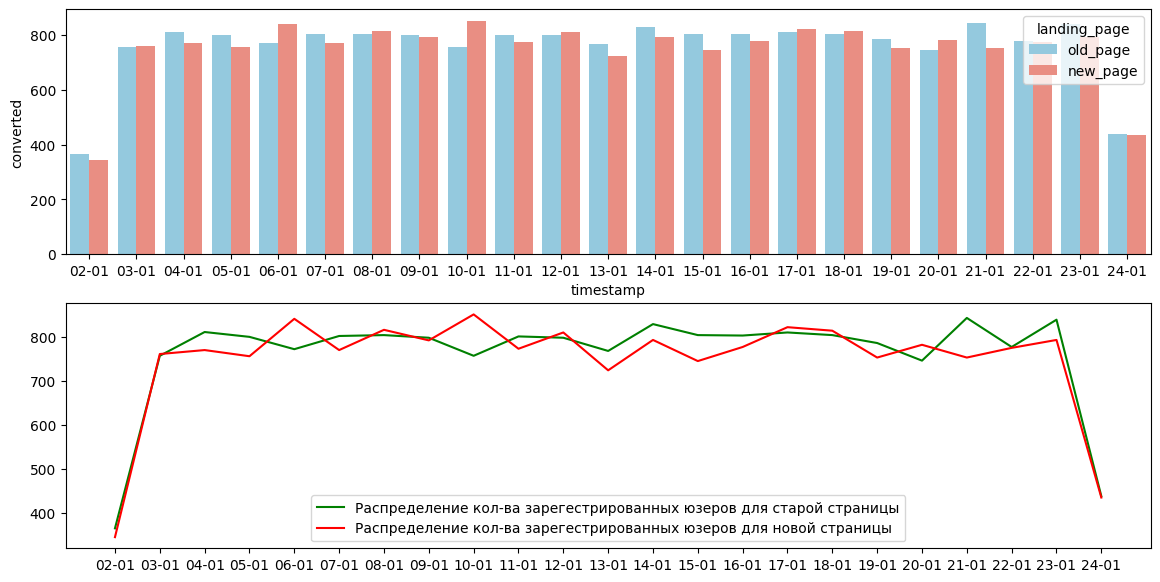

In [ ]:
df_for_barplot = clean_df.copy()
df_for_barplot['timestamp'] = df_for_barplot['timestamp'].dt.strftime('%d-%m')

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
sns.barplot(
    data=df_for_barplot.sort_values('timestamp'),
    x='timestamp',
    y='converted',
    hue='landing_page',
    palette=['skyblue', 'salmon'],
    estimator=np.sum, #по дефолту среднее
    errorbar=None) #показывает по дефолту стандартную ошибку, на не особ надо

plt.subplot(2, 1, 2)
counts_old_page = df_for_barplot[df_for_barplot['landing_page'] == 'old_page'].groupby(['timestamp', 'landing_page'])['converted'].sum().values
counts_new_page = df_for_barplot[df_for_barplot['landing_page'] == 'new_page'].groupby(['timestamp', 'landing_page'])['converted'].sum().values
plt.plot(np.unique(df_for_barplot['timestamp']), counts_old_page, label='Распределение кол-ва зарегестрированных юзеров для старой страницы', color='green')
plt.plot(np.unique(df_for_barplot['timestamp']), counts_new_page, label='Распределение кол-ва зарегестрированных юзеров для новой страницы', color='red')
plt.legend()

plt.show()

Распределение зарегестрировавшихся пользователей на курс - достаточно равномерное. Это может говорить о следующих вещах:

1.Компания работает стабильно(видим стабильное распределение)

2.Реклама распределена хорошо и постоянно привлекает клиентов

3.Отсутствие пиков - постоянные средние результаты(нет выдающихся взрывных показателей)

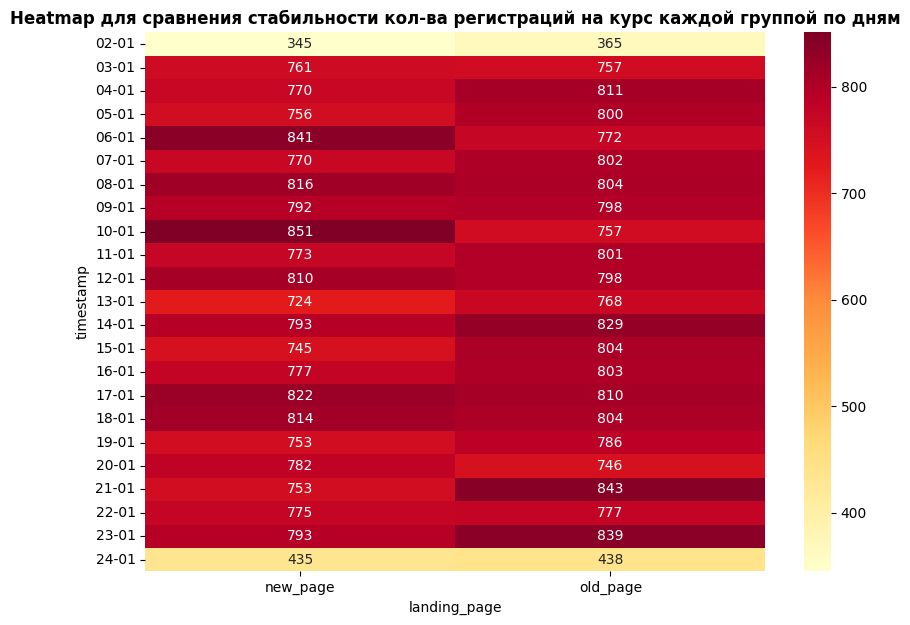

In [ ]:
clean_df_formatted_dt = clean_df.copy()
clean_df_formatted_dt['timestamp'] = clean_df_formatted_dt['timestamp'].dt.strftime('%d-%m')

pivot_table = pd.pivot_table(
    clean_df_formatted_dt,
    values='converted',
    index='timestamp',
    columns='landing_page',
    aggfunc='sum')

plt.figure(figsize=(10, 7))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlOrRd') #fmt='d' - decimal integers
plt.title('Heatmap для сравнения стабильности кол-ва регистраций на курс каждой группой по дням', fontweight='bold')
plt.show()

Как видим большую стабильность показывает группа, которой выдают старую страницу. Так как видны более плавные переходы и в целом одинаковые по цветам(соответственно и по соотношениям кол-ва регистраций в день к максимум по группе в целом) блоки.

Выберем метрику для A/B теста - это будет доля, зарегестрировашихся на курс от всех юзеров, которые открыли страницу в определенный день, для каждой из групп. Отобразим дата фрейм с которым будем работать и добавим новый признак - нашу метрику.

In [ ]:
conversion = clean_df.groupby(['timestamp', 'landing_page']).agg(
    registrated_users_per_day=('converted', 'sum'),
    total_users_per_day=('converted', 'count')
).reset_index()
conversion['conversion_rate'] = conversion['registrated_users_per_day'] / conversion['total_users_per_day']
conversion

,timestamp,landing_page,registrated_users_per_day,total_users_per_day,conversion_rate
0,2025-01-02,new_page,345,2873,0.120084
1,2025-01-02,old_page,365,2880,0.126736
2,2025-01-03,new_page,761,6675,0.114007
3,2025-01-03,old_page,757,6643,0.113955
4,2025-01-04,new_page,770,6578,0.117057
5,2025-01-04,old_page,811,6617,0.122563
6,2025-01-05,new_page,756,6557,0.115297
7,2025-01-05,old_page,800,6449,0.124050
8,2025-01-06,new_page,841,6772,0.124188
9,2025-01-06,old_page,772,6653,0.116038


In [ ]:
conversion.groupby(['timestamp', 'landing_page'])['conversion_rate'].sum()

timestamp   landing_page
2025-01-02  new_page        0.120084
            old_page        0.126736
2025-01-03  new_page        0.114007
            old_page        0.113955
2025-01-04  new_page        0.117057
            old_page        0.122563
2025-01-05  new_page        0.115297
            old_page        0.124050
2025-01-06  new_page        0.124188
            old_page        0.116038
2025-01-07  new_page        0.116244
            old_page        0.120892
2025-01-08  new_page        0.121248
            old_page        0.119732
2025-01-09  new_page        0.119367
            old_page        0.119982
2025-01-10  new_page        0.126788
            old_page        0.113510
2025-01-11  new_page        0.115494
            old_page        0.119267
2025-01-12  new_page        0.121988
            old_page        0.122374
2025-01-13  new_page        0.111214
            old_page        0.117252
2025-01-14  new_page        0.120188
            old_page        0.126681
2025-01-15  new_page        0.113654
            old_page        0.120126
2025-01-16  new_page        0.119135
            old_page        0.122129
2025-01-17  new_page        0.126190
            old_page        0.122858
2025-01-18  new_page        0.123859
            old_page        0.124362
2025-01-19  new_page        0.115420
            old_page        0.120073
2025-01-20  new_page        0.117453
            old_page        0.114646
2025-01-21  new_page        0.115579
            old_page        0.125446
2025-01-22  new_page        0.117247
            old_page        0.118662
2025-01-23  new_page        0.120517
            old_page        0.125938
2025-01-24  new_page        0.119178
            old_page        0.117238
Name: conversion_rate, dtype: float64

Точно также отобразим heatmap, но теперь уже для метрики.

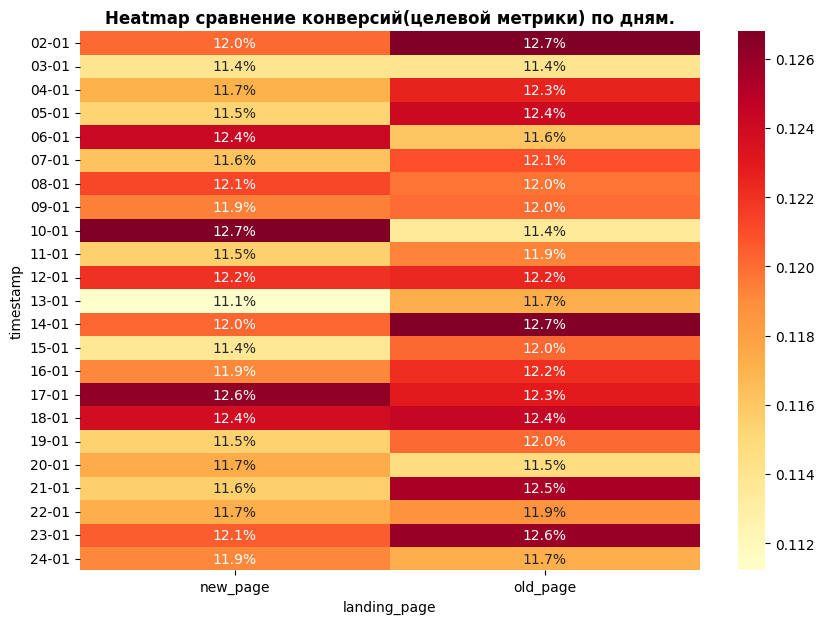

In [ ]:
conversion_formatted_dt = conversion.copy()
conversion_formatted_dt['timestamp'] = conversion_formatted_dt['timestamp'].dt.strftime('%d-%m')

pivot_table = pd.pivot_table(
    conversion_formatted_dt,
    values='conversion_rate',
    index='timestamp',
    columns='landing_page',
    aggfunc='sum'
)

plt.figure(figsize=(10, 7))
sns.heatmap(pivot_table, annot=True, fmt='.1%', cmap='YlOrRd')
plt.title('Heatmap сравнение конверсий(целевой метрики) по дням.', fontweight='bold')
plt.show()

По этой тепловой карте видно, что темно красных значений примерно одинаковое кол-во в обеих группах, а вот темно-оранжевых и оранжевых(которые не светлые) побольше в группе, которой показывали старую страницу.

Теперь рассмотрим распределение значений для метрики.

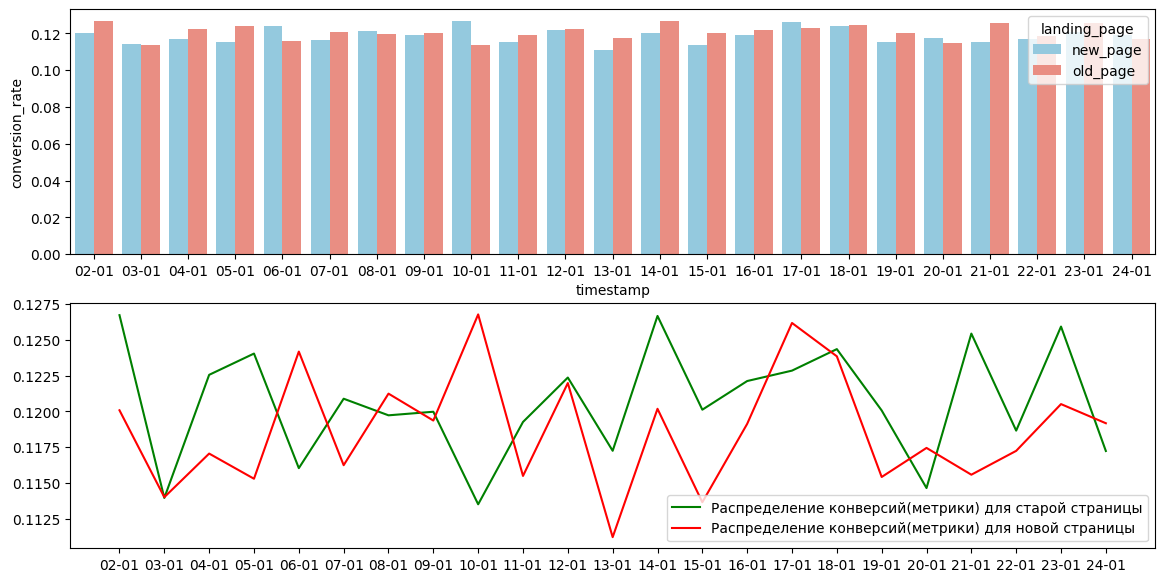

In [ ]:
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
sns.barplot(
    data=conversion_formatted_dt,
    x='timestamp',
    y='conversion_rate',
    hue='landing_page',
    palette=['skyblue', 'salmon'],
    estimator=np.sum, #по дефолту среднее
    errorbar=None) #показывает по дефолту стандартную ошибку, на не особ надо

plt.subplot(2, 1, 2)
counts_old_page = conversion_formatted_dt[conversion_formatted_dt['landing_page'] == 'old_page'].groupby(['timestamp', 'landing_page'])['conversion_rate'].sum().values
counts_new_page = conversion_formatted_dt[conversion_formatted_dt['landing_page'] == 'new_page'].groupby(['timestamp', 'landing_page'])['conversion_rate'].sum().values
plt.plot(np.unique(conversion_formatted_dt['timestamp']), counts_old_page, label='Распределение конверсий(метрики) для старой страницы', color='green')
plt.plot(np.unique(conversion_formatted_dt['timestamp']), counts_new_page, label='Распределение конверсий(метрики) для новой страницы', color='red')
plt.legend()

plt.show()

Пока что про распределение трудно что-то сказать. Проведем A/B тест для того, чтобы проверить есть ли статистически значимые различия между двумя группами. Вопрос только в том, каким тестом будем сравнивать? Проверим выборки на нормальность критерием Шапиро:

1. **Нулевая гипотеза $H_0$** — распределение заданной выборки и нормальное распределение одинаковы.
2. **Альтернативная гипотеза $H_1$** — распределение заданной выборки и нормальное распределение различны.

In [ ]:
X_1 = counts_old_page
Y_1 = counts_new_page
print(shapiro(X_1))
print(shapiro(Y_1))

ShapiroResult(statistic=np.float64(0.9623225286813013), pvalue=np.float64(0.5118382357213548))
ShapiroResult(statistic=np.float64(0.973206987264422), pvalue=np.float64(0.7651380524158462))


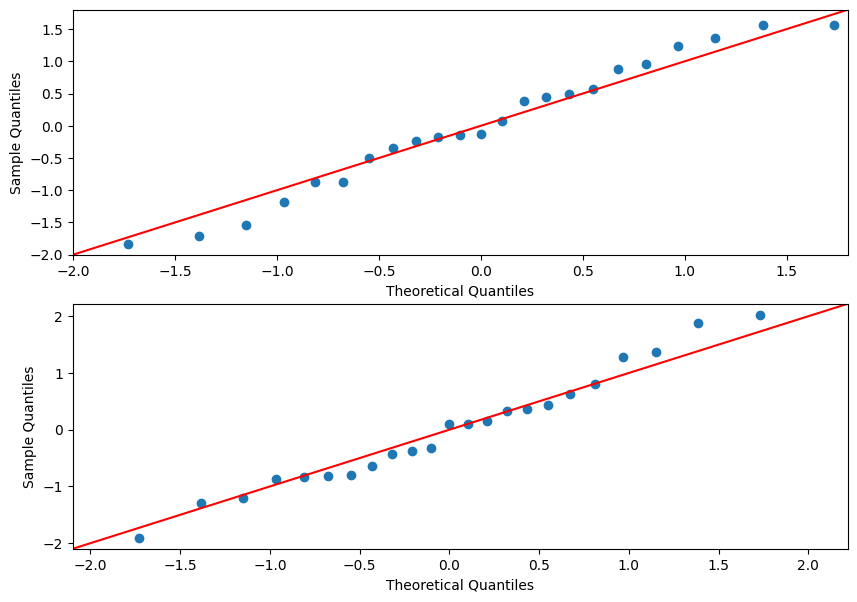

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))

qqplot(X_1, norm, line='45', fit=True, ax=ax1)
qqplot(Y_1, norm, line='45', fit=True, ax=ax2)

plt.show()

Видим, что ***p_value > 0.05 (уровень значимости, который мы взяли)***. Поэтому у нас нет оснований отвергать нулевые гипотезы и говорим, что данные распределены нормально в обоих выборках. Проверим выборки на гомогенность дисперсий:

In [ ]:
levene(X_1, Y_1)

LeveneResult(statistic=np.float64(0.006300064597971034), pvalue=np.float64(0.9370958880990291))

Видим также, что ***p_value > 0.05***. Дисперсии этих выборок гомогенны.

Для применения ***t-критерия Стьюдента*** данные должны удовлетворять следующим условиям:

- **несвязные выборки**:
    1. Гомогенность дисперсий — дисперсии внутри наших групп должны быть приблизительно одинаковыми
    2. Нормальность распределения (особенно важно для выборок с количеством наблюдений меньше 30)
    
    
- **связные выборки**:
    1. Нормальность распределения (особенно важно для выборок с количеством наблюдений меньше 30)

Выборки - несвязные, как приняли это ранее. Все условия применения ***t-критерий Стьюдента*** выполнены, поэтому можем его применить.

Сформируем гипотезы:

1. **Нулевая гипотеза $H_0$** — средняя конверсия по дням для двух групп одинакова.
2. **Альтернативная гипотеза $H_1$** — средняя конверсия по дням для двух групп различна.

In [ ]:
ttest_ind(X_1, Y_1, equal_var=True)

TtestResult(statistic=np.float64(1.5830297516697192), pvalue=np.float64(0.1205769793847066), df=np.float64(44.0))

***p_value > 0.05***

Поэтому нет оснований отвергать нулевую гипотезу, то есть различия между показателями выборок статистически не значимы. Проведем еще один тест используя bootstrap ([источник](https://www.geeksforgeeks.org/maths/bootstrap-method/?utm_source=chatgpt.com))

In [ ]:
n_bootstrap = 10000
bootstrap_p_values = []
bootstrap_mean_diffs = []

np.random.seed(2025)

for i in range(n_bootstrap):
    bootstrap_old = resample(X_1, replace=True, n_samples=len(X_1)) #resample() работает с numpy arrays, sample() с pandas DataFrame
    bootstrap_new = resample(Y_1, replace=True, n_samples=len(Y_1)) #Создает новую выборку случайным образом из существующих данных
                                                                    #replace=True - элементы выборки могут повторяться(браться из нее несколько раз)
    mean_diff = np.mean(bootstrap_new) - np.mean(bootstrap_old)
    bootstrap_mean_diffs.append(mean_diff)

print(f"Среднее разности средних по группам: {np.mean(bootstrap_mean_diffs)}")
print(f"Доверительный интервал: [{float(np.percentile(bootstrap_mean_diffs, 2.5))} ; {float(np.percentile(bootstrap_mean_diffs, 97.5))}]")

Среднее разности средних по группам: -0.0018752281888442743
Доверительный интервал: [-0.004141524098042608 ; 0.0003593082475967627]


Как видим, по среднему разности средних можно сказать, что чуть получше результаты показала старая страница с точки зрения результативности регистрации на курс. Однако посмотрев на доверительный интервал можем опять же сказать, что различия не являются статистически значимыми. Так как в интервале присутствует 0 - неопределенность в значении данных. (Интерпретировать можно так: с 95% уверенностью можем сказать, что истинная разница в средних значений конверсий в регистрацию по группам лежит между значениями -0.004141524098042608 и 0.0003593082475967627). Посмотрим на графике как выглядят значения bootstrap_mean_diffs:

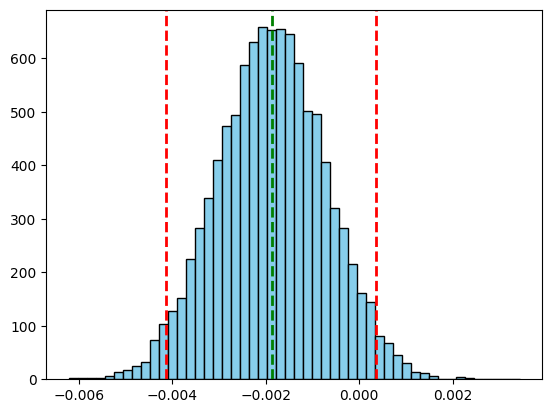

In [ ]:
lower_bound = float(np.percentile(bootstrap_mean_diffs, 2.5))
upper_bound = float(np.percentile(bootstrap_mean_diffs, 97.5))
mean_of_means_diff = np.mean(bootstrap_mean_diffs)
plt.hist(bootstrap_mean_diffs, bins=50, color='skyblue', edgecolor='black', label='Распределение разностей средних')
plt.axvline(x=lower_bound, color='red', linestyle='--', linewidth=2)
plt.axvline(x=upper_bound, color='red', linestyle='--', linewidth=2)
plt.axvline(x=mean_of_means_diff, color='green', linestyle='--', linewidth=2)
plt.show()

Таким образом, нет доказательств того, что новая страница лучше или хуже себя показала. Однако относительно 0, доверительный интервал больше уходит в отрицательную сторону. Это значит, что вероятность того, что новый вариант может быть хуже старого - больше, чем вероятность того, что новая страница покажет лучшие результаты в сравнении со старой страницей. Таким образом, мы бы рекомендовали оставить старый вариант страницы.

(Новая страница не показала статистически значимого улучшения. Более того, доверительный интервал смещен в сторону потенциального ухудшения конверсии (0.41%), что в 11.3 раз превышает максимальный потенциал улучшения (0.036%). Рекомендуется сохранить текущую страницу.)

### Часть 2

#### Описание датасета 2 части


Я перечислю все 18 колонок, как они обычно есть в CSV, и объясню, что каждая значит.


1–2. **Administrative, Administrative_Duration**


Administrative
Тип: числовой (целое).
Что это: сколько административных страниц посетил пользователь.
Административные страницы — это всякие настройки аккаунта, логин, инфо о профиле, FAQ, политика, контактные страницы и т.п.


Administrative_Duration
Тип: числовой (вещественное).
Что это: общее время (в секундах), проведённое на административных страницах за эту сессию.
Если эти значения высокие → человек возится с аккаунтом, читает инфу, возможно, настраивает что-то перед покупкой или наоборот просто “шастает” без покупки.
3–4. Informational, Informational_Duration
Informational
Тип: числовой (целое).
Что это: сколько информационных страниц посетил пользователь.
Информационные страницы — это страницы с контентом/информацией о сервисе, условиях, доставке, описаниями, справкой.


Informational_Duration
Тип: числовой (вещественное).
Что это: общее время (секунды), проведённое на информационных страницах.
Высокие значения могут говорить о том, что человек изучает условия/инфу, но ещё не ушёл в товары.


5–6. ProductRelated, ProductRelated_Duration
ProductRelated
Тип: числовой (целое).
Что это: количество посещённых “товарных” страниц (страницы каталогов, карточки товаров и т.п.).
ProductRelated_Duration
Тип: числовой (вещественное).
Что это: общее время (секунды), проведённое на товарных страницах.
Это ключевые колонки: они описывают глубину взаимодействия с товарами. Как правило, у купивших они выше.


7–8. BounceRates, ExitRates
BounceRates
Тип: числовой (доля).
Что это: показатель отказов для соответствующей страницы/сессии (из логов сайта).
Примерно: доля людей, которые ушли с сайта после просмотра только одной страницы.
ExitRates
Тип: числовой (доля).
Что это: показатель выхода — доля людей, которые покинули сайт с этой страницы.
Чем выше эти метрики, тем “хуже” поведение с точки зрения продолжения сессии. Часто у непокупателей BounceRates/ExitRates выше.


9. PageValues
PageValues — числовой показатель, отражающий коммерческую ценность страниц, просмотренных в рамках сессии: чем выше PageValues, тем более “приближённым к покупке” был пользовательский маршрут (страницы, ассоциированные с доходом/покупкой). Нулевые значения означают, что для данной сессии “ценность” просмотров не была зафиксирована, а дробные — потому что показатель является расчётным (усреднённым), а не счётчиком действий.


10. SpecialDay
SpecialDay
Тип: числовой (вещественное, от 0 до 1).
Что это: показатель “близости” сессии к какому-то особому дню (например, День святого Валентина).
Значения ближе к 1 означают, что сессия произошла очень близко к особому дню, значения около 0 — далеко от него.
Можно смотреть, растёт ли конверсия, когда SpecialDay близок к 1 (могут быть эффекты промо/скидок/праздничного спроса).


11. Month
Month
Тип: категориальный (строка).
Что это: месяц, в который происходила сессия (например: "Feb", "Mar", "May", "Nov", "Dec" и т.д.).
Можно анализировать сезонность: в какие месяцы люди чаще покупают (праздники, распродажи, зимний/летний спрос и т.д.).


12. OperatingSystems
OperatingSystems
Тип: числовой (целое, код).
Что это: ID операционной системы, с которой зашёл пользователь.
Это код: 1, 2, 3, … (например, разные значения могут соответствовать Windows, MacOS, Linux, Android, iOS и т.п., но в датасете не обязательно есть расшифровка).
Можно смотреть, есть ли разницы в поведении/конверсии в зависимости от ОС (десктоп/мобилка).


13. Browser
Browser
Тип: числовой (целое, код).
Что это: ID браузера, через который зашёл пользователь (Chrome, Firefox, Safari и т.п. — но тоже в виде кодов).
Иногда определённые браузеры связаны с мобилками/десктопом, старым/новым UI и т.п. Можно проверить, есть ли там перекосы.


14. Region
Region
Тип: числовой (целое).
Что это: код региона, из которого зашёл юзер.
Не конкретная страна/город, а именно код.
Можно смотреть конверсию по регионам: где аудитория “качественнее”.


15. TrafficType
TrafficType
Тип: числовой (целое).
Что это: тип источника трафика (код: прямой заход, поиск, реклама, реферальный и т.п.).
Это очень важная вещь для маркетинга: откуда пришёл человек и как это связано с покупкой.


16. VisitorType
VisitorType
Тип: категориальный (строка).
Обычно значения:
"New_Visitor" — новый посетитель,
"Returning_Visitor" — возвратный (уже был раньше),
иногда "Other".
Что это: тип пользователя с точки зрения истории взаимодействия с сайтом.
Как правило, возвратные (Returning_Visitor) конвертируются лучше, и это отличный кандидат для гипотезы.


17. Weekend
Weekend
Тип: булевый (True/False).
Что это: флаг, была ли сессия в выходной день.
Очень удобно для проверки гипотезы “покупают ли люди чаще в выходные”.


18. Revenue
Revenue
Тип: булевый (True/False).
Что это: целевая переменная — произошла ли покупка в этой сессии.
True — пользователь в этой сессии совершил покупку,
False — не совершил.
Это аналог вашей converted в A/B-тесте. Вся часть 2 будет крутиться вокруг неё.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.utils import resample
from scipy.stats import ttest_ind

In [ ]:
a = pd.read_csv('online_shoppers_intention.csv')
a.head()
df = a

Всего у нас 18 признаков

Ключевые :

Administrative, Informational, ProductRelated + их *_Duration;


BounceRates, ExitRates, PageValues, SpecialDay;

Month, OperatingSystems, Browser, Region, TrafficType, VisitorType, Weekend.

возбмем за целевую переменную revenue — совершил ли пользователь покупку (True/False)

#### Очистка датасета


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

пропусков у нас нет

In [ ]:
#рассмотрим дубликаты
df_clean = df.copy()
df_clean.duplicated().sum()

#то есть у нас 125 строк где совпадают все колонки

np.int64(125)

либо повторно записанные одинаковые сессии,
либо технический дубль при выгрузке

лучше удалим, чтобы не было двоения одной и той же сессии

In [ ]:
df_clean = df_clean.drop_duplicates()

еще не супер круто, что у нас месяц - объектный тип, переведем его в кат. чтобы было далее полегче работать

In [ ]:
cat_cols = ['Month']

for col in cat_cols:
    df_clean[col] = df_clean[col].astype('category')
#просто как будто более логично Но хз

In [ ]:
df_clean.describe().T

#тут отрицательных штук нет значит все окей


,count,mean,std,min,25%,50%,75%,max
Administrative,12205.0,2.338878,3.330436,0.0,0.000000,1.000000,4.000000,27.000000
Administrative_Duration,12205.0,81.646331,177.491845,0.0,0.000000,9.000000,94.700000,3398.750000
Informational,12205.0,0.508726,1.275617,0.0,0.000000,0.000000,0.000000,24.000000
Informational_Duration,12205.0,34.825454,141.424807,0.0,0.000000,0.000000,0.000000,2549.375000
ProductRelated,12205.0,32.045637,44.593649,0.0,8.000000,18.000000,38.000000,705.000000
ProductRelated_Duration,12205.0,1206.982457,1919.601400,0.0,193.000000,608.942857,1477.154762,63973.522230
BounceRates,12205.0,0.020370,0.045255,0.0,0.000000,0.002899,0.016667,0.200000
ExitRates,12205.0,0.041466,0.046163,0.0,0.014231,0.025000,0.048529,0.200000
PageValues,12205.0,5.949574,18.653671,0.0,0.000000,0.000000,0.000000,361.763742
SpecialDay,12205.0,0.061942,0.199666,0.0,0.000000,0.000000,0.000000,1.000000


у нас есть такие переменные как

ProductRelated, ProductRelated_Duration они нам показывают количество посещённых “товарных” страниц (страницы каталогов, карточки товаров и т.п.)

ProductRelated_Duration - общее время (секунды), проведённое на товарных страницах.

и понятное дело не может быть такого, что ProductRelated>0, при этом ProductRelated_Duration ==0 например. поэтому тоже это проверим и уберем все, что показывает такую несостыковку.



In [ ]:
sum((df['ProductRelated'] > 0) & (df['ProductRelated_Duration'] == 0))

717

In [ ]:
# оставляем только те строки, где НЕ (ProductRelated > 0 и ProductRelated_Duration == 0)
df_clean = df_clean[(df_clean['ProductRelated'] > 0) & (df_clean['ProductRelated_Duration'] == 0)]

также в датасете есть такие пары, как:

**Administrative** - сколько административных страниц посетил пользователь.

и

**Administrative_Duration** - общее время (в секундах), проведённое на административных страницах за эту сессию.



**Informational** - сколько информационных страниц посетил пользователь.

 и

**Informational_Duration** - время на этих страницах

проверим эти пары также на аналогичное соответствие, так как елси хоть один из признаков по парам равен нулю, следовательно второй точно не может быть больше нуля.

In [ ]:
eror_admin = (df['Administrative'] > 0) & (df['Administrative_Duration'] == 0)
eror_info  = (df['Informational']  > 0) & (df['Informational_Duration']  == 0)


print(eror_admin.sum(), eror_info.sum())

135 226


In [ ]:
eror_admin2 = (df['Administrative'] == 0) & (df['Administrative_Duration'] > 0)
eror_info2  = (df['Informational']  == 0) & (df['Informational_Duration']  > 0)


eror_admin2.sum(), eror_info2.sum()


(np.int64(0), np.int64(0))

In [ ]:
sum((df['ProductRelated'] == 0) & (df['ProductRelated_Duration'] > 0))
sum((df['Administrative'] == 0) & (df['Administrative_Duration'] > 0))
sum((df['Informational'] == 0) & (df['Informational_Duration'] > 0))

0

In [ ]:
df_clean = df_clean[(df_clean['Administrative'] > 0) & (df_clean['Administrative_Duration'] == 0)]
df_clean = df_clean[(df_clean['Informational'] > 0) & (df_clean['Informational_Duration'] == 0)]

https://docs-python.ru/packages/modul-pandas-analiz-dannykh-python/metod-dataframe-query/ вот здесь взяла этот query

в нашем датасете довольно "хвостатые" метрики, поэтому стоит рассмотреть те, которые мы будем далее использовать в гипотезах и очистить данные метрики от выбросов

для очистки мы использовали метод IQR. Сейчас более точно рассмотрим все метрики и обьясним, почему некоторые из них мы вообще не трогаем:

BounceRates, ExitRates — НЕ чистим:

они по определению ограничены [0; 1] - это нормальные значения долей

SpecialDay — НЕ чистим

это не “измерение времени”, а шкала близости к праздникам

Administrative, Informational, ProductRelated — НЕ чистим


это счётчики (0,1,2) — большие значения могут быть редкими, но реальным
(человек много листал)


если убирать хвосты, можно убить именно то поведение, которое хотим изучать


Browser, Region, TrafficType, Month, VisitorType, OperatingSystems — НЕ чистим


это категории

Бинарные Weekend, Revenue — НЕ чистим

рассмотрим Informational_Duration (это у нас общее время (секунды), проведённое на информационных страницах)

так как мы дальше работаем с данной метрикой избавимся от выбросов в этой метрике с помощью IQR

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# IQR-очистка выбросов ТОЛЬКО для ProductRelated_Duration
# -----------------------------

col = 'ProductRelated_Duration'

# 1) (Опционально) убираем физически невозможные значения
# Время не может быть отрицательным → такие строки точно ошибка / артефакт трекинга
df = df[df[col] >= 0].copy()

# 2) Считаем квартиль Q1 (25%) и Q3 (75%)
# Q1 — значение, ниже которого лежит 25% наблюдений
# Q3 — значение, ниже которого лежит 75% наблюдений
# Квартильный подход хорош тем, что он устойчив к хвостам распределения
Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)

# 3) Считаем межквартильный размах (IQR)
# IQR = Q3 - Q1 — “ширина” центральных 50% данных
# То есть насколько “разбросаны” значения внутри основной массы распределения

IQR = Q3 - Q1

# Определяем границы нормального диапазона по правилу 1.5*IQR
# Все значения ниже lower_bound или выше upper_bound считаем выбросами
# 1.5 — стандартный коэффициент для поиска выбросов по “ящику с усами” (boxplot)

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


# 5) Выведем границы, чтобы понимать масштаб и что мы именно режем

print("Q1 (25%):", Q1)
print("Q3 (75%):", Q3)
print("IQR (Q3-Q1):", IQR)
print("Lower bound:", lower_bound)
print("Upper bound:", upper_bound)



# 6) Создаём маску выбросов:
# True — это строки, которые являются выбросами по этому признаку


outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)

# 7) Смотрим, сколько выбросов нашли
print("Всего строк:", df.shape[0])
print("Выбросов по IQR:", outlier_mask.sum())
print("Доля выбросов:", outlier_mask.mean())

# 8) Удаляем выбросы → оставляем только строки, которые НЕ являются выбросами
df_clean = df[~outlier_mask].copy()

print("Строк после очистки:", df_clean.shape[0])


Q1 (25%): 184.1375
Q3 (75%): 1464.1572135000001
IQR (Q3-Q1): 1280.0197135
Lower bound: -1735.8920702500002
Upper bound: 3384.1867837500004
Всего строк: 12330
Выбросов по IQR: 961
Доля выбросов: 0.07793998377939984
Строк после очистки: 11369


In [ ]:
df_clean = df_clean[df_clean['ProductRelated_Duration'] >= 0].copy()

#Считаем квартиль Q1 (25%) и Q3 (75%)

Q1 = df_clean['ProductRelated_Duration'].quantile(0.25)
Q3 = df_clean['ProductRelated_Duration'].quantile(0.75)
IQR = Q3 - Q1

# Определяем границы нормального диапазона по правилу 1.5*IQR
# Все значения ниже lower_bound или выше upper_bound считаем выбросами


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Q1:", Q1)
print("Q3:", Q3)
print("IQR:", IQR)


Q1: 161.2
Q3: 1193.0
IQR: 1031.8


In [ ]:
mask = (df_clean['ProductRelated_Duration'] < lower_bound) | (df_clean['ProductRelated_Duration'] > upper_bound)
#True —  строки, которые являются выбросами по этому признаку

mask.sum()

np.int64(389)

In [ ]:
df_clean = df_clean[~mask].copy()

In [ ]:
df_clean.shape[0]

10980

In [ ]:
mask = (df_clean['ProductRelated_Duration'] < lower_bound) | (df_clean['ProductRelated_Duration'] > upper_bound)

mask

,ProductRelated_Duration
0,False
1,False
2,False
3,False
4,False
...,...
12325,False
12326,False
12327,False
12328,False


In [ ]:
df_clean['ProductRelated_Duration'].max()

2735.728571

In [ ]:
df_clean['ProductRelated_Duration'].quantile(0.999)
#вот здесь уже числа выглядят нереальными поэтому все после этого
#перцентиля просто кикаем

qu9 = df_clean['ProductRelated_Duration'].quantile(0.999)

это у нас скорее всего проосто незакрытый сайт был всю ночь, но прикладного смысла это нам не даст никакого, так как человек просто забыл закрыть комп

In [ ]:
# оставляем только строки ниже или равные 99.9 перцентилю
df_clean = df_clean[df_clean['ProductRelated_Duration'] <= qu9]

In [ ]:
df_clean = df

In [ ]:
df['Revenue'].value_counts(normalize=True)

,proportion
Revenue,
False,0.845255
True,0.154745


Около 15% сессий заканчиваются покупкой. Класс несбалансирован: покупателей заметно меньше, чем непокупателей

чтобы легче потом было работать с этим разделим признаки на категориальные и числовые

In [ ]:
numeric_cols = [
    'Administrative',
    'Administrative_Duration',
    'Informational',
    'Informational_Duration',
    'ProductRelated',
    'ProductRelated_Duration',
    'BounceRates',
    'ExitRates',
    'PageValues',
    'SpecialDay',
    'OperatingSystems',
    'Browser',
    'Region',
    'TrafficType'
]

In [ ]:
cat_cols = [
    'Month',
    'VisitorType',
    'Weekend',
    'Revenue']

Числовые признаки будем использовать для расчёта описательной статистики

Категориальные признаки — для анализа распределений

посмотрим на корреляцию признаков (числовых)

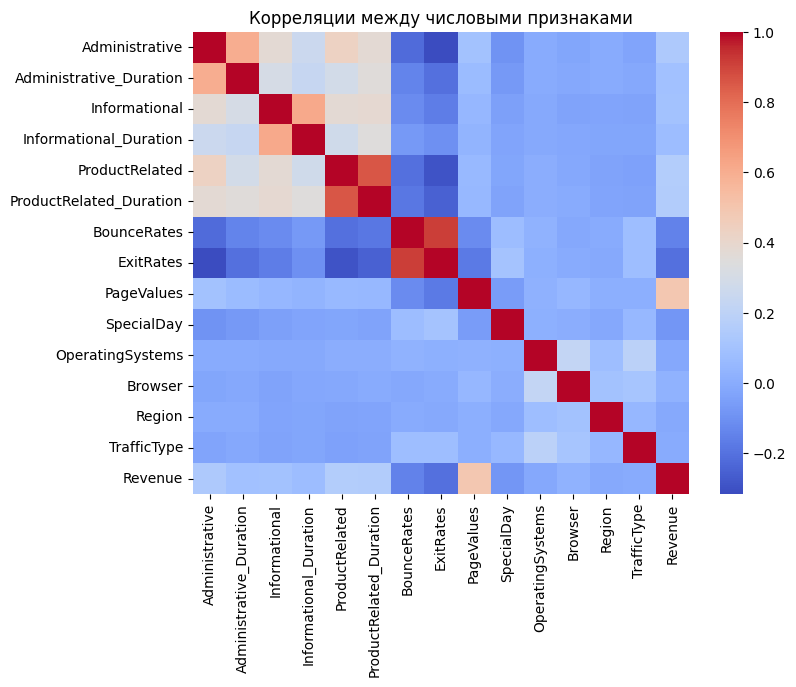

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols + ['Revenue']].corr(),  cmap='coolwarm')
plt.title('Корреляции между числовыми признаками')
plt.show()

заметим, что здесь видно связь:

1) page value и revenue

ProductRelated_Duration + ProductRelated тоже  


#### Future Engineering



Feature Extraction



In [ ]:
# Общее количество страниц в сессии
df['TotalPages'] = ( df['Administrative'] +df['Informational'] +df['ProductRelated'])

df.head()


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,TotalPages
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False,2
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False,2
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False,10


теперь для более удобного дальнейшего анализав рассмотрим доли разных типов страниц

In [ ]:
# чтобы сравнивать сессии разной длины
df['Product_part'] = df['ProductRelated'] / df['TotalPages']
df['Info_part'] = df['Informational'] / df['TotalPages']
df['Admin_part'] = df['Administrative'] / df['TotalPages']

df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,TotalPages,Product_part,Info_part,Admin_part
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,1,1,1,Returning_Visitor,False,False,1,1.0,0.0,0.0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,2,1,2,Returning_Visitor,False,False,2,1.0,0.0,0.0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,1,9,3,Returning_Visitor,False,False,1,1.0,0.0,0.0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,2,2,4,Returning_Visitor,False,False,2,1.0,0.0,0.0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,3,1,4,Returning_Visitor,True,False,10,1.0,0.0,0.0


In [ ]:
#общее время на сайте
df['Total_time'] = (df['Administrative_Duration'] +df['Informational_Duration'] +df['ProductRelated_Duration'])
df.head()


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Region,TrafficType,VisitorType,Weekend,Revenue,TotalPages,Product_part,Info_part,Admin_part,Total_time
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,1,1,Returning_Visitor,False,False,1,1.0,0.0,0.0,0.000000
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,1,2,Returning_Visitor,False,False,2,1.0,0.0,0.0,64.000000
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,9,3,Returning_Visitor,False,False,1,1.0,0.0,0.0,0.000000
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,2,4,Returning_Visitor,False,False,2,1.0,0.0,0.0,2.666667
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,1,4,Returning_Visitor,True,False,10,1.0,0.0,0.0,627.500000


#### Гипотеза 1

В выходные у людей больше времени -  конверсия может отличаться от будней (в лучшую сторону)

проверим эту штуку через z тест.
тогда у нас нулевая гипотеза: (конверсия в выходные равна конверсии в будни).
альтернативная гипотеза: (конверсии различаются)

берем именно z тест потому что мы сразвниваем именно долю покупателей в выходные и в будни. Mann–Whitney- тест для чисел, когда мы сравниваем распределение значений, а так как у нас Revenue — это 0 или 1, просто купил / не купил берем z

***лекция:***


Выбор статистического критерия

 Метрика — доля / бинарная (конверсия, CTR, доля пользователей, купивших
товар)
→ Используй z-тест для пропорций или χ²-тест.

In [ ]:
from scipy.stats import norm


conv_weekend = df[df['Weekend'] == True]['Revenue']   # конверсии в выходные
conv_weekday = df[df['Weekend'] == False]['Revenue']  # конверсии в будни


p_weekend = conv_weekend.mean()  #это наша доля покупок (так как там только 0 и 1)
p_weekday = conv_weekday.mean()  #same

n_weekend = conv_weekend.shape[0]   #просто размер
n_weekday = conv_weekday.shape[0]

print( p_weekend, p_weekday)

0.17398884239888424 0.1489114352145424


In [ ]:
se_weekend = np.sqrt(p_weekend * (1 - p_weekend) / n_weekend)
se_weekday = np.sqrt(p_weekday * (1 - p_weekday) / n_weekday)

se_diff = np.sqrt(se_weekend ** 2 + se_weekday ** 2)

print(se_diff)

#стандартная ошибка

0.007968985455062751


In [ ]:
diff = p_weekend - p_weekday            # разность конверсий
z = diff / se_diff                      # z-статистика

In [ ]:
q = norm.cdf(z)

print('p_weekend = %.4f, p_weekday = %.4f' % (p_weekend, p_weekday))
print('diff = %.4f, z = %.2f, q = %.3f' % (diff, z, q))

p_value_two_sided = 2 * min(q, 1 - q)
print('two-sided p-value = %.4f' % p_value_two_sided)

p_weekend = 0.1740, p_weekday = 0.1489
diff = 0.0251, z = 3.15, q = 0.999
two-sided p-value = 0.0017


p-value меньше 0,05
нулевую гипотезу конверсии одинаковы отвергаем.
статистически значимые различия есть, и в выходные пользователи действительно покупают чаще, чем в будни.

Конверсия в выходные: 17.4%
Конверсия в будни: 14.9%
Разница: +2.5 п.п. в пользу выходных.




проведем сравнительный анализ нескольких тестов друг с другом для данной гипотезы. Будем использовать данный тест так как у нас Метрика — бинарная.

H0: конверсия в выходные = конверсии в будни (Revenue не зависит от Weekend)


H1: конверсии различаются (есть зависимость)


In [ ]:
import numpy as np
from scipy.stats import chi2_contingency



#Считаем "купил/не купил" (counts)

conv_weekend = df[df['Weekend'] == True]['Revenue']   # конверсии в выходные
conv_weekday = df[df['Weekend'] == False]['Revenue']  # конверсии в будни

buy_weekend = conv_weekend.sum()
buy_weekend

np.int64(499)

In [ ]:
dont_buy_weekend = conv_weekend.shape[0] - buy_weekend

buy_weekday = conv_weekday.sum()

dont_buy_weekday = conv_weekday.shape[0] - buy_weekday


In [ ]:
# Собираем таблицу сопряженности
# строки: [выходные, будни]
# столбцы: [купил, не купил]

c_table = np.array([[buy_weekend,  dont_buy_weekend],[buy_weekday,  dont_buy_weekday]])
c_table

array([[ 499, 2369],
       [1409, 8053]])

In [ ]:
# χ²-тест

chi2_contingency(c_table)



Chi2ContingencyResult(statistic=np.float64(10.390978319534856), pvalue=np.float64(0.0012663251061221968), dof=1, expected_freq=array([[ 443.80729927, 2424.19270073],
       [1464.19270073, 7997.80729927]]))

p-value = 0.0012663251061221968

p-value < 0.05

то есть отвергаем H0 - конверсия статистически отличается (есть зависимость Weekend ↔ Revenue).

***ВЫВОД***:

по данным конверсия в выходные выше примерно на 2.5 процентных пункта, и это отличие статистически подтверждается двумя независимыми критериями - можно обоснованно рассматривать weekend как фактор, который стоит учитывать.

Тест 1 — z-тест

p-value = 0.0017


Тест 2 — χ²-тест

Мы проверили зависимость между:

признак 1: Weekend (True/False)
признак 2: Revenue (купил/не купил)



p-value = 0.00114


Вывод: при уровне значимости 0.05 отвергаем H0 - Weekend и факт покупки статистически зависимы (т.е. конверсия отличается).

***БИЗНЕС ВЫВОД***




1) Усилить коммерческую активность в выходные


Планировать основные скидки/подборки/рассылки так, чтобы пик приходился на сб–вс.


2) Подготовить сайт и поддержку под рост “готовности купить”

Если выходные дают больше покупок, то есть смысл:
усилить именно в эти дни - работу чата, ответов, доставки,
убедиться, что оплата работает максимально стабильно,
ускорить страницы товара (чтобы не терять “горячую” аудиторию).



#### 2 Гипотеза: влияние времени на покупку

------------------------------------------------------------


То есть как ProductRelated_Duration влияет на Revenue

пользователи, которые проводят больше времени на товарных страницах, чаще совершают покупку чем те, кто сидит там меньше.

разделяем выборку на группы (revenue) : купили/не купили (там и так true/false поэтому как раз будет 2 группы)

**нулевая гипотеза**:  распределения ProductRelated_Duration в двух группах одинаковы


**альтренативная гипотеза:** распределения отличаются. (у совершивших покупку другое время)

мы можем рассмотреть сначала revenue (как в целом выглядит эта переменная, чтобы понимать, какой тест будет использовать логичнее)

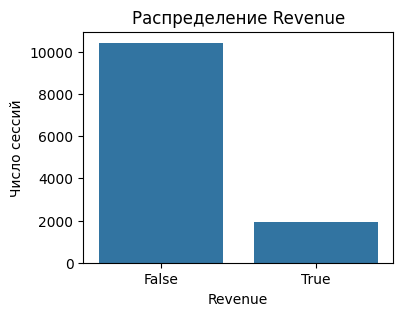

In [ ]:
plt.figure(figsize=(4, 3))
sns.countplot(x='Revenue', data=df)
plt.title('Распределение Revenue')
plt.xlabel('Revenue')
plt.ylabel('Число сессий')
plt.show()

как мы уже ранее подчеркивали это не нормальное распределение (ну это в целом булевая переменная 1/0 соотв-й true/false

будем использовать тест Манна-Уитни так как данные распределены не нормально, также не подчиняются закону нормального распрделения

также посмотрим медианы для понимания среднего времени в каждом классе:


In [ ]:
from scipy.stats import mannwhitneyu
t_group = df[df['Revenue'] == True ]['ProductRelated_Duration']
f_group = df[df['Revenue'] == False]['ProductRelated_Duration']

stat, p_value = mannwhitneyu(t_group, f_group)

print(f"Статистика теста: {stat}, p-значение: {p_value}")

Статистика теста: 13382713.0, p-значение: 5.332268364164621e-128


у нас p value очень очень маленькое(практически равное нулю) : то есть это точно меньше, чем 0.05. тогда точно мы отвергаем нулевую гипотезу.

Это подтверждает идею, что более долгое взаимодействие с каталогом и карточками товара связано с более высоким шансом покупки. С точки зрения продукта и маркетинга это повод развивать механики, которые “затягивают” пользователя в изучение товаров: рекомендации, подборки, что будет увеличивать время посещения сайта и изучение продукта. также возможно часть решений "купить" рождается в моменте изучения самого сайта.

In [ ]:
print(t_group.median())
print(f_group.median())

1109.90625
510.19


по медианам просто видно, что время сильно отличается (группа которая в итоге совершила покупку - больше времени проводит на сайте)

#### Гипотеза 3

__________________________________________________________________________________________

ГИПОТЕЗА:



 Конверсия максимальна при умеренной доле административных и информационных страниц относительно товарных, при этом если инфо/админ страниц нет совсем или наоборот слишком много, конверсия ниже.  


Мы хотим посмотреть, как сочетается навигация по “инфо” страницам и по товарным, и влияет ли это на вероятность покупки.

идея: если человек вообще не смотрит административные и информационные страницы (не читает условия доставки, оплаты, возврата и т.д.), возможно, он не доверяет магазину и уходит.


Если человек слишком много времени проводит на инфо/админ страницах, возможно, он сомневается, ищет подвох и в итоге тоже не покупает.


Есть предположение, что существует “золотая середина”:
человек зашёл на несколько инфо страниц, получил достаточно инфы пошёл в товары и там купил.

мы рассматриваем ProductRelated >0, так как нам нужно чтобы был общий просмотр сайта и карточек товаров


In [ ]:
df_now = df[df['ProductRelated'] > 0].copy()

у нас прям есть признак Administrative - это как раз сколько административных страниц посетил пользователь. также берем Informational- сколько информационных страниц посетил пользователь. тогда прям создадим новый признак, который будет состоять из 2х данных составляющих, как суммы.

In [ ]:
df_now['add_pages'] = df_now['Administrative'] + df_now['Informational']
df_now.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,TrafficType,VisitorType,Weekend,Revenue,TotalPages,Product_part,Info_part,Admin_part,Total_time,add_pages
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,1,Returning_Visitor,False,False,1,1.0,0.0,0.0,0.000000,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,2,Returning_Visitor,False,False,2,1.0,0.0,0.0,64.000000,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,3,Returning_Visitor,False,False,1,1.0,0.0,0.0,0.000000,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,4,Returning_Visitor,False,False,2,1.0,0.0,0.0,2.666667,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,4,Returning_Visitor,True,False,10,1.0,0.0,0.0,627.500000,0


то есть нам это будет показывать, сколько мы посмотрели страниц именно адм. + инф. в сумме


почитаем теперь отношение количества инфо страниц к обычным товарным страницам

In [ ]:
df_now['dolya_add'] = df_now['add_pages'] / df_now['ProductRelated']
df_now.head(50)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,VisitorType,Weekend,Revenue,TotalPages,Product_part,Info_part,Admin_part,Total_time,add_pages,dolya_add
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,...,Returning_Visitor,False,False,1,1.000000,0.000000,0.000000,0.000000,0,0.000000
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,...,Returning_Visitor,False,False,2,1.000000,0.000000,0.000000,64.000000,0,0.000000
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,...,Returning_Visitor,False,False,1,1.000000,0.000000,0.000000,0.000000,0,0.000000
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,...,Returning_Visitor,False,False,2,1.000000,0.000000,0.000000,2.666667,0,0.000000
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,...,Returning_Visitor,True,False,10,1.000000,0.000000,0.000000,627.500000,0,0.000000
5,0,0.0,0,0.0,19,154.216667,0.015789,0.024561,0.000000,0.0,...,Returning_Visitor,False,False,19,1.000000,0.000000,0.000000,154.216667,0,0.000000
6,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.4,...,Returning_Visitor,False,False,1,1.000000,0.000000,0.000000,0.000000,0,0.000000
8,0,0.0,0,0.0,2,37.000000,0.000000,0.100000,0.000000,0.8,...,Returning_Visitor,False,False,2,1.000000,0.000000,0.000000,37.000000,0,0.000000
9,0,0.0,0,0.0,3,738.000000,0.000000,0.022222,0.000000,0.4,...,Returning_Visitor,False,False,3,1.000000,0.000000,0.000000,738.000000,0,0.000000
10,0,0.0,0,0.0,3,395.000000,0.000000,0.066667,0.000000,0.0,...,Returning_Visitor,False,False,3,1.000000,0.000000,0.000000,395.000000,0,0.000000


In [ ]:
df_now['add_pages'].describe()

,add_pages
count,12292.000000
mean,2.823625
std,3.983303
min,0.000000
25%,0.000000
50%,1.000000
75%,4.000000
max,41.000000


dolya_add = 0 - были только товарные страницы, инфо/админ не было

dolya_add = 0.2 - примерно 1 инфо/админ страница на 5 товарных

dolya_add = 1 - инфо/админ страниц столько же, сколько товарных

dolya_add > 1 - человек провёл больше “кликов” по инфо/админ, чем по товар



теперь нужно все разбить по группам


1) 0 — только товары
человек ходил только по товарным страницам,
вообще не заходил в инфо


2) мало навигации (0 < x ≤ 0.5)
немного инфо страниц, но товары доминируют


3) умеренная навигация (0.5 < x ≤ 1.5)
примерно сопоставимое количество инфо и товарных страниц

 и почитал, и товары посмотрел.


4) много навигации (x > 1.5)
человек больше временив тратит на инфо, чем на товары


In [ ]:
def add_group(row):
    r = row['dolya_add']

    if r == 0:
        return '0 — только товары'
    elif r <= 0.5:
        return 'мало навигации'
    elif r <= 1.5:
        return 'умеренная навигация'
    else:
        return 'много навигации'

df_now['add_group'] = df_now.apply(add_group, axis=1)
df_now.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Weekend,Revenue,TotalPages,Product_part,Info_part,Admin_part,Total_time,add_pages,dolya_add,add_group
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,False,False,1,1.0,0.0,0.0,0.000000,0,0.0,0 — только товары
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,False,False,2,1.0,0.0,0.0,64.000000,0,0.0,0 — только товары
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,False,False,1,1.0,0.0,0.0,0.000000,0,0.0,0 — только товары
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,False,False,2,1.0,0.0,0.0,2.666667,0,0.0,0 — только товары
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,True,False,10,1.0,0.0,0.0,627.500000,0,0.0,0 — только товары


In [ ]:
df_now['add_group'].value_counts()

,count
add_group,
мало навигации,6279
0 — только товары,5299
умеренная навигация,613
много навигации,101


In [ ]:
conv_by_new = df_now.groupby('add_group')['Revenue'].mean().sort_values(ascending=False)
conv_by_new

,Revenue
add_group,
мало навигации,0.220099
много навигации,0.168317
умеренная навигация,0.123980
0 — только товары,0.080581


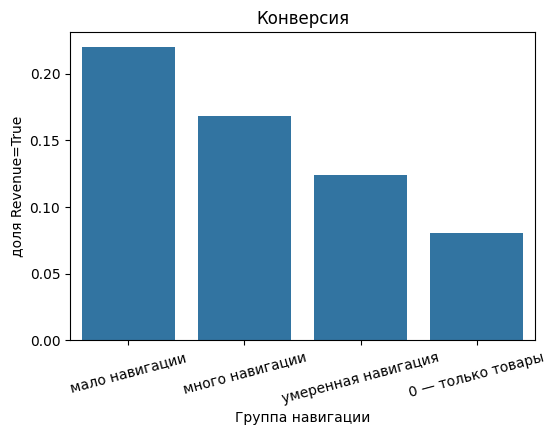

In [ ]:

plt.figure(figsize=(6,4))
sns.barplot(x=conv_by_new.index, y=conv_by_new.values)
plt.ylabel('доля Revenue=True')
plt.xlabel('Группа навигации')
plt.title('Конверсия')
plt.xticks(rotation=15)
plt.show()


пупупу мы обломались :) дальше вообще нет смысла строчить

#### Гипотеза 4


**Цель**

Понять, отличается ли “коммерческая ценность” поведения пользователей, которые купили, в зависимости от месяца, и сохраняется ли ноябрьский эффект конверсии, если учитывать тип пользователя (New vs Returning).

Что именно проверяем

Мы смотрим только на тех пользователей, которые завершили сессию покупкой (Revenue = True), и анализируем и сравниваем распределение PageValues по месяцам.

**Важно по смыслу:**

PageValues — числовой показатель, отражающий коммерческую ценность страниц, просмотренных в рамках сессии: чем выше PageValues, тем более “приближённым к покупке” был маршрут пользователя (страницы, ассоциированные с доходом/покупкой).
Нули означают, что “ценность” просмотров в сессии не была зафиксирована, а дробные значения — потому что показатель расчётный (усреднённый), а не счётчик действий.

**Задаемся вопросом:**

Если PageValues у купивших различается по месяцам, значит “качество/ценность” маршрута купивших меняется сезонно:
в одни месяцы люди покупают после более “ценного” поведения на сайте (выше PageValues), в другие — покупка происходит с меньшей “ценностью” просмотренных страниц.

**Формально:**

H₀: распределение PageValues у купивших в ноябре не отличается от остальных месяцев.

H₁: распределение PageValues у купивших в ноябре отличается от остальных месяцев.

Отдельный интересующий нас кейс - ноябрь: мы хотим понять, чем он отличается от остальных месяцев по глубине воронки среди тех, кто всё-таки купил.

Как будем подходить

Берём только покупки (Revenue = True), чтобы смотреть именно путь тех, кто дошёл до конца воронки.

При необходимости чистим PageValues от явно аномальных значений (крайний хвост), чтобы на результат не влияли “бессмысленные” сессии.

Сравниваем распределения PageValues по месяцам. Сначала описательно (медианы, IQR, боксплоты), затем формально с помощью непараметрического теста, т.к. PageValues скособочен.

Проверяем отдельную гипотезу “Ноябрь vs остальные месяцы”. Если у покупателей в ноябре PageValues системно выше/ниже, чем в другие месяцы, это говорит о другом поведении в воронке в пик сезона.

Проблема наивного подхода

Если просто посмотреть на конверсию по месяцам, мы увидим, что:

Ноябрь - чемпион по конверсии.

Но это может быть обманчиво. Возможно, в ноябре на сайт пришла “более удобная” аудитория (например, больше Returning_Visitor, которые и так конвертируются лучше), и весь эффект объясняется сменой состава аудитории, а не самим месяцем.

Мы хотим проверить это честно, разложив конверсию по типам пользователей.

Что именно хотим доказать

**Формулировка гипотезы:**

“Ноябрь даёт значимый прирост конверсии и у новых, и у возвратных пользователей. То есть эффект месяца не объясняется только тем, кто именно пришёл на сайт”.

Формально - для каждого типа посетителя отдельно:

H₀: конверсия в ноябре такая же, как в остальные месяцы.

H₁: конверсия в ноябре отличается (ожидаем, что выше).

Мы делаем это отдельно для New_Visitor и Returning_Visitor, чтобы проверить:

внутри новых пользователей: “Ноябрь vs остальные месяцы”;

внутри возвратных: “Ноябрь vs остальные месяцы”.

**2.3. Как будем подходить**

Сегментируем данные по типу пользователя: New_Visitor и Returning_Visitor.

Для каждого сегмента:

считаем конверсию по месяцам (доля Revenue = True);

отдельно считаем конверсию в ноябре и в остальные месяцы вместе.

Сравниваем конверсию в ноябре и в остальных месяцах внутри одного типа пользователя:

получаем оценку конверсий (“в ноябре было X%, в другие месяцы Y%”),

проверяем, статистически ли значима эта разница.

**Интерпретируем:**

Если у новых в ноябре конверсия значимо выше, и у возвратных в ноябре конверсия тоже значимо выше, тогда можно говорить, что ноябрьский эффект устойчив внутри сегментов, а не за счёт перераспределения состава аудитории.

После выполнения обеих частей мы сможем:

Показать, что поведение покупателей в ноябре по глубине воронки (PageValues) отличается от других месяцев.

Показать, что ноябрьский рост конверсии сохраняется как у новых, так и у возвращающихся пользователей, то есть:

это не просто “в ноябре пришло больше лояльных”, а именно сезонный/промо-эффект, который реально влияет на вероятность покупки внутри каждого сегмента.

Перейдем к самой практической части:

In [ ]:
from scipy.stats import kruskal, mannwhitneyu

In [ ]:
df_ready = df.copy()

Мы анализируем только тех, кто купил, и их PageValues по месяцам.

In [ ]:
df_page = df_ready[df_ready['Revenue'] == True].copy()

df_page.shape
df_page[['Month', 'PageValues']].head()

,Month,PageValues
65,Feb,22.916036
76,Feb,11.439412
101,Feb,17.535959
188,Mar,1.706015
196,Mar,19.342650


In [ ]:
df_page['PageValues'].describe()

,PageValues
count,1908.000000
mean,27.264518
std,35.191954
min,0.000000
25%,3.641144
50%,16.758134
75%,38.897742
max,361.763742


Видно по describe():

count = 1908 — столько покупок попало в df_page.

mean ≈ 27.3, median ≈ 16.8. Видим, что среднее заметно больше медианы. Значит распределение правоскошенное

75% ≈ 38.9, а max ≈ 361.8. Видим, что максимум почти в 10 раз больше верхнего квартиля. Есть очень длинные сессии, похожие на выбросы (в духе “вкладку забыли закрыть”).

Посмотрим верхние перцентили и аккуратно отрезать хвост по какому-то уровню (99, 99.5, 99.9).

In [ ]:
df_page['PageValues'].quantile([0.95, 0.99, 0.995, 0.999])

,PageValues
0.950,88.797531
0.990,154.059290
0.995,222.497858
0.999,294.742755


Для анализа глубины воронки мы отсеяли верхние 0.5% значений PageValues как потенциальные аномалии (крайний правый хвост)

In [ ]:
q_995 = df_page['PageValues'].quantile(0.995)
q_995

np.float64(222.49785792649936)

In [ ]:
df_page_new = df_page[df_page['PageValues'] <= q_995].copy()

df_page_new['PageValues'].describe()

,PageValues
count,1898.000000
mean,25.944347
std,30.030612
min,0.000000
25%,3.585739
50%,16.626217
75%,38.175225
max,218.864910


**Сводка PageValues по месяцам**

In [ ]:
pagevalues_month = (df_page_new.groupby('Month')['PageValues'].agg(['count', 'median', 'mean']).reset_index()) #reset_index() берёт текущий индекс (Month) и превращает его в обычный столбец

pagevalues_month

,Month,count,median,mean
0,Aug,76,16.544036,24.456123
1,Dec,213,23.001945,33.732960
2,Feb,3,17.535959,17.297136
3,Jul,66,6.927143,16.113984
4,June,29,17.727223,17.128564
5,Mar,191,19.534955,28.933168
6,May,363,25.389259,34.137246
7,Nov,757,8.533928,20.110483
8,Oct,115,22.372762,29.585830
9,Sep,85,13.594200,24.028000


Глубина воронки (PageValues) у купивших явно различается по месяцам, и ноябрь выделяется тем, что люди покупают быстрее (меньше PageValues), хотя конверсия при этом самая высокая.

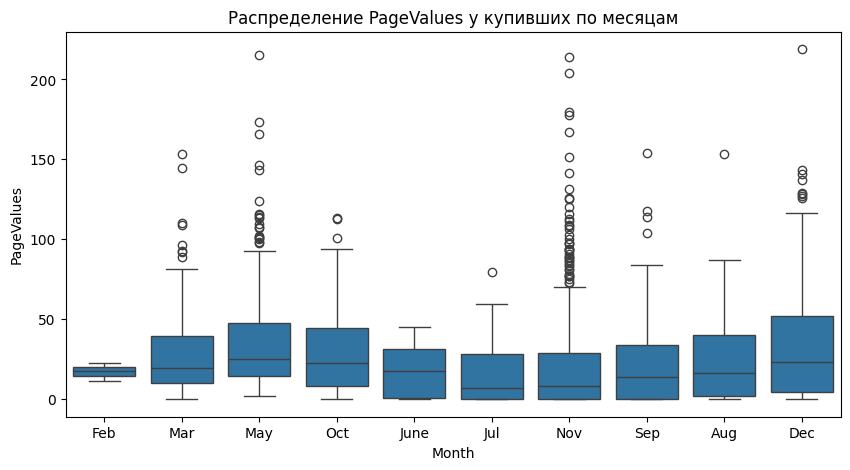

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_page_new, x='Month', y='PageValues')
plt.title('Распределение PageValues у купивших по месяцам')
plt.show()

График показывает, что коммерческая ценность маршрута купивших пользователей (PageValues) заметно различается по месяцам: медианы и разбросы по месяцам не одинаковые, значит “типичный” уровень PageValues у купивших сезонно меняется.

Июль и ноябрь выделяются самыми низкими медианами и большим количеством значений, близких к нулю — это говорит о том, что в эти месяцы покупка у значимой части пользователей происходит при относительно низкой “ценности” просмотренных страниц (маршрут менее “ценностный” по метрике).

Май и декабрь выглядят как месяцы с более высокими медианами и более широким IQR: среди купивших чаще встречаются сессии с более высокой коммерческой ценностью поведения перед покупкой.

Почти во всех месяцах видно много выбросов (очень большие PageValues), что указывает на сильную правостороннюю асимметрию: есть небольшая доля сессий с очень “ценным” поведением перед покупкой. Поэтому визуально заметен “хвост”, и дальше логично использовать непараметрические тесты для сравнения месяцев.

**Про ноябрь (по boxplot):**

На графике ноябрь выделяется тем, что среди купивших пользователей медианное значение PageValues одно из самых низких, а нижняя часть распределения “прижата” к малым значениям. Это означает, что в ноябре покупка у значимой доли пользователей происходит при относительно низкой коммерческой ценности просмотренных страниц (по метрике PageValues) - то есть в этот месяц часть аудитории приходит более “готовой” и принимает решение без необходимости проходить через много “ценностных” шагов на сайте.

**Тест Манна–Уитни: “Ноябрь vs остальные месяцы”**

Хочется уточнить, почему мы применяем именно тест Манна-Уитни

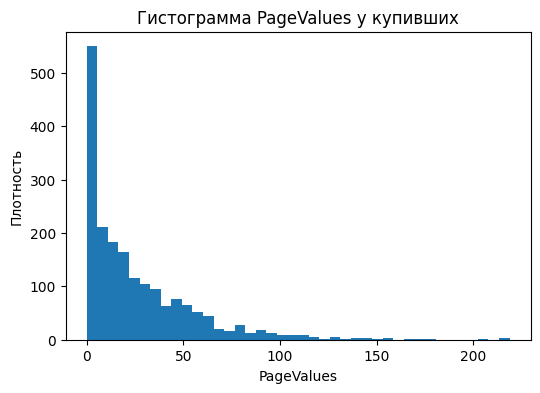

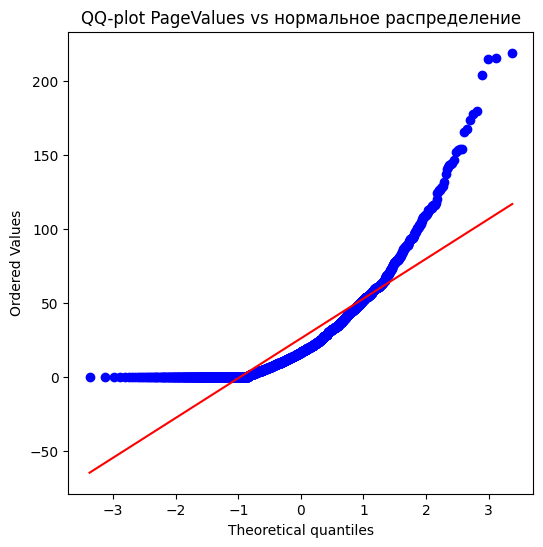

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# 1. Гистограмма PageValues у купивших
plt.figure(figsize=(6, 4))
plt.hist(df_page_new['PageValues'], bins=40)
plt.title('Гистограмма PageValues у купивших')
plt.xlabel('PageValues')
plt.ylabel('Плотность')
plt.show()

# 2. QQ-plot для PageValues
plt.figure(figsize=(6, 6))
stats.probplot(df_page_new['PageValues'], dist="norm", plot=plt)
plt.title('QQ-plot PageValues vs нормальное распределение')
plt.show()

Поскольку мы сравнивали глубину прохождения воронки (PageValues) между двумя независимыми группами: покупатели в ноябре и покупатели в остальные месяцы Распределение PageValues у купивших пользователей сильно скошено вправо: среднее заметно выше медианы, на гистограмме виден длинный правый хвост, а QQ-plot показывает существенное отклонение квантилей выборки от квантилей нормального распределения.

Поэтому для сравнения мы использовали непараметрический критерий Манна–Уитни.

H₀: распределения PageValues у купивших в ноябре и в остальные месяцы одинаковы.

H₁: распределения различаются.

In [ ]:
from scipy.stats import mannwhitneyu

# Покупатели в ноябре
nov = df_page_new[df_page_new['Month'] == 'Nov']['PageValues']

# Покупатели в остальные месяцы
others = df_page_new[df_page_new['Month'] != 'Nov']['PageValues']

len(nov), len(others)

(757, 1141)

In [ ]:
print('Медиана PageValues в ноябре:', nov.median())
print('Среднее PageValues в ноябре:', nov.mean())

print('Медиана PageValues в остальных месяцах:', others.median())
print('Среднее PageValues в остальных месяцах:', others.mean())

Медиана PageValues в ноябре: 8.533928457
Среднее PageValues в ноябре: 20.1104832792391
Медиана PageValues в остальных месяцах: 21.2112655
Среднее PageValues в остальных месяцах: 29.814841441714286


In [ ]:
stat_mw, p_mw = mannwhitneyu(nov, others)

print('Статистика Манна–Уитни:', stat_mw)
print('p-value:', p_mw)

Статистика Манна–Уитни: 306034.5
p-value: 3.3278139930262264e-27


Отвергаем H₀: распределения PageValues у купивших в ноябре и в остальные месяцы различаются. И так как медиана и среднее в ноябре ниже, чем в другие месяцы, направление эффекта такое:

Покупатели в ноябре в среднем проходят меньший путь по воронке (меньше PageValues), чем покупатели в остальные месяцы.

Если проанализировать, что это может значить в жизни людей и проанализировать почему именно ноябрь является месяцем более быстры покупок, то можно прийти к выводу, что это легко объясняется различными акциями по типу Black Friday и т.п., т.е. люди принимают решение о покупке быстрее, им нужно меньше «ценности страниц», чтобы дойти до покупки.

**Переходим ко второй части гипотезы**

**Сводка конверсий по месяцам и типу пользователя**

In [ ]:
conv_month = (df_ready.groupby(['Month', 'VisitorType'])['Revenue'].agg(['mean', 'count', 'sum']).reset_index())
# mean = конверсия, sum = число покупок
conv_month.rename(columns={
    'mean': 'conversion',
    'count': 'sessions',
    'sum': 'purchases'
}, inplace=True)

conv_month

,Month,VisitorType,conversion,sessions,purchases
0,Aug,New_Visitor,0.291667,72,21
1,Aug,Returning_Visitor,0.152355,361,55
2,Dec,New_Visitor,0.223881,335,75
3,Dec,Other,0.209677,62,13
4,Dec,Returning_Visitor,0.096241,1330,128
5,Feb,New_Visitor,0.000000,1,0
6,Feb,Returning_Visitor,0.016393,183,3
7,Jul,New_Visitor,0.203704,54,11
8,Jul,Returning_Visitor,0.145503,378,55
9,June,New_Visitor,0.233333,30,7


на описательном уровне видно, ноябрьская конверсия максимальна и у новых, и у возвратных пользователей.

Будем использовать Z-test, так как Revenue это бинарная переменная (0/1). Когда мы берём среднее по 0/1, мы фактически считаем долю успехов

Z-тест опирается на центральную пределку: при достаточно большом числе наблюдений распределение доли p близко к нормальному.

У нас:

New_Visitor: ноябрь - 419 сессий, 128 покупок. Следлвательно и успехов, и неуспехов >> 5

остальные месяцы: 1275 / 294 также ок

Returning_Visitor:

ноябрь - 2557 / 629

остальные месяцы - 7994 / 841

Во всех случаях выборки очень большие, условия выполняются с запасом, значит нормальное приближение для долей корректно, z-test работает устойчиво.

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

def ztest_conversion(pokupki_nov, n_nov, pokupki_other, n_other):
    #pokupki_nov   — количество покупок в ноябре
    #n_nov         — количество сессий в ноябре
    #pokupki_other — покупки в остальные месяцы
    #n_other       — сессии в остальные месяцы
    counts = [pokupki_nov, pokupki_other]
    nobs   = [n_nov, n_other]
    z_stat, p_value = proportions_ztest(count=counts, nobs=nobs)
    return z_stat, p_value

H₀: конверсия New_Visitor в ноябре = конверсии New_Visitor в остальные месяцы.

H₁: конверсия New_Visitor в ноябре выше конверсии New_Visitor в остальные месяцы.

In [ ]:
df_new = df_ready[df_ready['VisitorType'] == 'New_Visitor']

nov_new   = df_new[df_new['Month'] == 'Nov']
other_new = df_new[df_new['Month'] != 'Nov']

pokupki_nov_new   = nov_new['Revenue'].sum()
n_nov_new         = nov_new.shape[0]

pokupki_other_new = other_new['Revenue'].sum()
n_other_new       = other_new.shape[0]

print('New_Visitor - ноябрь: сессий =', n_nov_new, ', покупок =', pokupki_nov_new)
print('New_Visitor - остальные месяцы: сессий =', n_other_new, ', покупок =', pokupki_other_new)

print('Конверсия в ноябре:', pokupki_nov_new / n_nov_new)
print('Конверсия в остальные месяцы:', pokupki_other_new / n_other_new)

z_new, p_new = ztest_conversion(pokupki_nov_new, n_nov_new,pokupki_other_new, n_other_new)

print('New_Visitor - z-статистика:', z_new)
print('New_Visitor - p-value:', p_new)

New_Visitor - ноябрь: сессий = 419 , покупок = 128
New_Visitor - остальные месяцы: сессий = 1275 , покупок = 294
Конверсия в ноябре: 0.3054892601431981
Конверсия в остальные месяцы: 0.23058823529411765
New_Visitor - z-статистика: 3.0754366517331744
New_Visitor - p-value: 0.0021019457487418936


Конверсия новых пользователей в ноябре = 30.5% (128 покупок из 419 сессий).

Конверсия новых пользователей в остальные месяцы = 23.1% (294 покупок из 1275 сессий).

Z-статистика ≈ 3.08, p-value ≈ 0.0021 < 0.05.

При уровне значимости 5% отвергаем H₀ в пользу H₁: конверсия New_Visitor в ноябре статистически значимо выше, чем в остальные месяцы. Рост составляет примерно +7.5 п.п. (с ~23% до ~30.5%), что подтверждает наличие “ноябрьского буста” для новых пользователей.

H₀: конверсия возвратных пользователей в ноябре такая же, как в остальные месяцы.

H₁: конверсия возвратных пользователей в ноябре выше, чем в остальные месяцы.

In [ ]:
# Берём только возвратных пользователей
df_vozv = df_ready[df_ready['VisitorType'] == 'Returning_Visitor']

nov_vozv   = df_vozv[df_vozv['Month'] == 'Nov']
other_vozv = df_vozv[df_vozv['Month'] != 'Nov']

pokupki_nov_vozv   = nov_vozv['Revenue'].sum()
n_nov_vozv         = nov_vozv.shape[0]

pokupki_other_vozv = other_vozv['Revenue'].sum()
n_other_vozv       = other_vozv.shape[0]

print('Returning_Visitor - ноябрь: сессий =', n_nov_vozv, ', покупок =', pokupki_nov_vozv)
print('Returning_Visitor — остальные месяцы: сессий =', n_other_vozv, ', покупок =', pokupki_other_vozv)

print('Конверсия в ноябре:', pokupki_nov_vozv / n_nov_vozv)
print('Конверсия в остальные месяцы:', pokupki_other_vozv / n_other_vozv)

z_vozv, p_vozv = ztest_conversion(pokupki_nov_vozv, n_nov_vozv, pokupki_other_vozv, n_other_vozv)

print('Returning_Visitor — z-статистика:', z_vozv)
print('Returning_Visitor — p-value:', p_vozv)

Returning_Visitor - ноябрь: сессий = 2557 , покупок = 629
Returning_Visitor — остальные месяцы: сессий = 7994 , покупок = 841
Конверсия в ноябре: 0.24599139616738366
Конверсия в остальные месяцы: 0.10520390292719539
Returning_Visitor — z-статистика: 17.895045977331236
Returning_Visitor — p-value: 1.2889041390779646e-71


Из результатов:

Ноябрь:

сессий = 2557, покупок = 629

конверсия ≈ 0.246 (24.6%)

Остальные месяцы:

сессий = 7994, покупок = 841

конверсия ≈ 0.105 (10.5%)

z-статистика ≈ 17.90

p-value ≈ 1.29 · 10⁻⁷¹ (практически 0, намного меньше 0.05)

При уровне значимости 5% уверенно H₀: конверсия Returning_Visitor в ноябре статистически значимо выше, чем в остальные месяцы.

Рост конверсии для возвратных пользователей очень большой: примерно с 10.5% до 24.6% (плюс ~14 процентных пунктов). То есть “ноябрьский буст” особенно сильен именно у Returning_Visitor.

**Финалим две проверки:**

Общая гипотеза звучала следующим образом:

в ноябре поведение пользователей, которые совершают покупку, отличается от остальных месяцев:

по глубине прохождения воронки (PageValues);

по конверсии, причём ноябрьский рост конверсии сохраняется внутри каждого типа пользователя (New_Visitor и Returning_Visitor), а не возникает только из-за смены состава аудитории.

Итог по всей гипотезе

**Объединяя обе части, получаем:**

Поведение купивших в ноябре отличается от остальных месяцев по глубине воронки: покупатели в ноябре в среднем проходят короче путь (PageValues ниже), чем покупатели в другие месяцы, что говорит о более быстром принятии решения в “горячий сезон”.

“Ноябрьский буст” конверсии устойчив внутри обоих ключевых сегментов: и у новых, и у возвратных пользователей конверсия в ноябре значимо выше, чем в остальные месяцы;

особенно сильный рост виден у Returning_Visitor.

Следовательно, повышенная ноябрьская конверсия не является простым следствием смены состава аудитории. Даже если “заморозить” тип пользователя, ноябрь сам по себе даёт дополнительный эффект: пользователи чаще покупают и делают это быстрее.

Ноябрь — действительно особый месяц: промо-активность/Black Friday не только приводит больше людей, но и подталкивает и новых, и возвратных пользователей быстрее доводить сессию до покупки.

#### Гипотеза 5: Новые пользователи, которые дольше изучают товарные страницы, чаще совершают покупки

Формулировка гипотезы:

Н0: Время, проведенное новыми пользователями на товарных страницах, не влияет на вероятность покупки.

Н1: Новые пользователи, которые проводят больше времени на товарных страницах, чаще совершают покупки.

In [ ]:
new_visitors = df[df['VisitorType'] == 'New_Visitor'].copy()

In [ ]:
bought = new_visitors[new_visitors['Revenue'] == True]['ProductRelated_Duration']
not_bought = new_visitors[new_visitors['Revenue'] == False]['ProductRelated_Duration']

In [ ]:
print(f"Новых пользователей всего: {len(new_visitors)}")
print(f"Из них купили: {len(bought)} ({len(bought)/len(new_visitors)*100:.1f}%)")
print(f"Не купили: {len(not_bought)} ({len(not_bought)/len(new_visitors)*100:.1f}%)")
print()
print(f"Среднее время на товарных страницах у купивших: {bought.mean():.1f} сек")
print(f"Среднее время на товарных страницах у не купивших: {not_bought.mean():.1f} сек")
print(f"Медианное время у купивших: {bought.median():.1f} сек")
print(f"Медианное время у не купивших: {not_bought.median():.1f} сек")

Новых пользователей всего: 1694
Из них купили: 422 (24.9%)
Не купили: 1272 (75.1%)

Среднее время на товарных страницах у купивших: 874.2 сек
Среднее время на товарных страницах у не купивших: 557.5 сек
Медианное время у купивших: 689.4 сек
Медианное время у не купивших: 335.1 сек


In [ ]:
t, p_bought = stats.shapiro(bought.sample(len(bought)))
t, p_not_bought = stats.shapiro(not_bought.sample(len(not_bought)))


In [ ]:
print(f"Проверка нормальности:")
print(f"p-value для купивших: {p_bought:.4f} {'(нормальное)' if p_bought > 0.05 else '(не нормальное)'}")
print(f"p-value для не купивших: {p_not_bought:.4f} {'(нормальное)' if p_not_bought > 0.05 else '(не нормальное)'}")

Проверка нормальности:
p-value для купивших: 0.0000 (не нормальное)
p-value для не купивших: 0.0000 (не нормальное)


Из теста Шапиро-Уилко следует, что распределение купивших и не купивших не является нормальным. Построим графики распределения, чтобы поонять, какой стат. тест стоит применить.

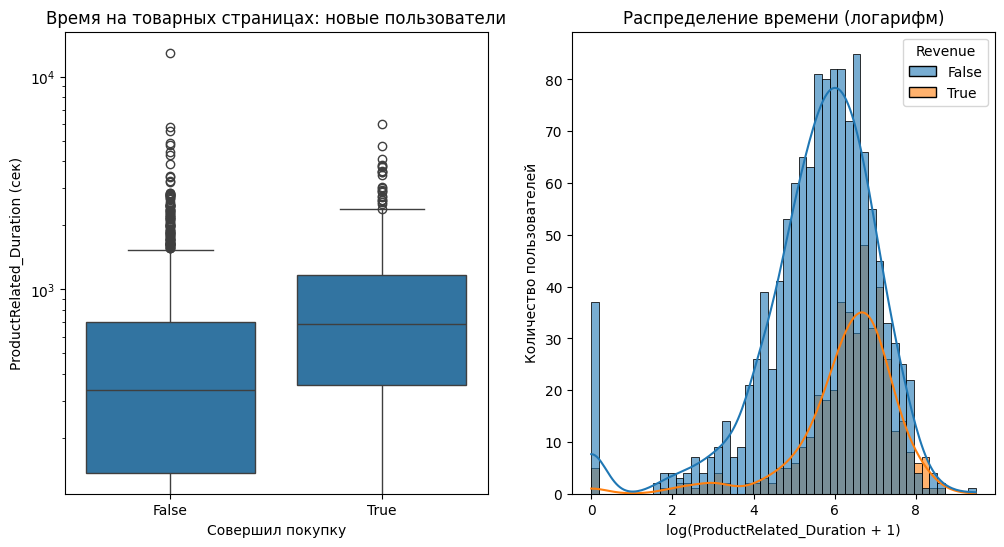

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='Revenue', y='ProductRelated_Duration', data=new_visitors)
plt.title('Время на товарных страницах: новые пользователи')
plt.xlabel('Совершил покупку')
plt.ylabel('ProductRelated_Duration (сек)')
plt.yscale('log')

plt.subplot(1, 2, 2)

sns.histplot(data=new_visitors, x=np.log1p(new_visitors['ProductRelated_Duration']),
             hue='Revenue', bins=50, kde=True, alpha=0.6)
plt.title('Распределение времени (логарифм)')
plt.xlabel('log(ProductRelated_Duration + 1)')
plt.ylabel('Количество пользователей')

plt.show()

Для неясного распределения бинарной величины стоит использовать U-тест Манье-Уитни.

In [ ]:
stat, p_value = stats.mannwhitneyu(bought, not_bought, alternative='two-sided')
print(f"Статистика: {stat:.2f}")
print(f"p-value: {p_value}")


Статистика: 359344.00
p-value: 1.5403463394373174e-25


p-value меньше порогого значения, а значит нулевая гипотеза отвергается

Чтобы убедиться, что наши суждения не ошибочны - проведем бутстрап

In [ ]:
n_bootstrap = 10000
bootstrap_p_values = []
bootstrap_mean_diffs = []
X_1 = bought
Y_1 = not_bought


for i in range(n_bootstrap):
    bootstrap_old = resample(X_1, replace=True, n_samples=len(X_1)) #resample работает с numpy arrays, sample с pandas DataFrame
    bootstrap_new = resample(Y_1, replace=True, n_samples=len(Y_1)) #Создает новую выборку случайным образом из существующих данных
                                                                    #replace=True - элементы выборки могут повторяться(браться из нее несколько раз)
    mean_diff = np.mean(bootstrap_new) - np.mean(bootstrap_old)
    bootstrap_mean_diffs.append(mean_diff)


print(f"Среднее разности средних по группам: {np.mean(bootstrap_mean_diffs)}")
print(f"Доверительный интервал: [{float(np.percentile(bootstrap_mean_diffs, 2.5))} ; {float(np.percentile(bootstrap_mean_diffs, 97.5))}]")

Среднее разности средних по группам: -317.57216196165706
Доверительный интервал: [-405.95145225509594 ; -232.23065138039968]


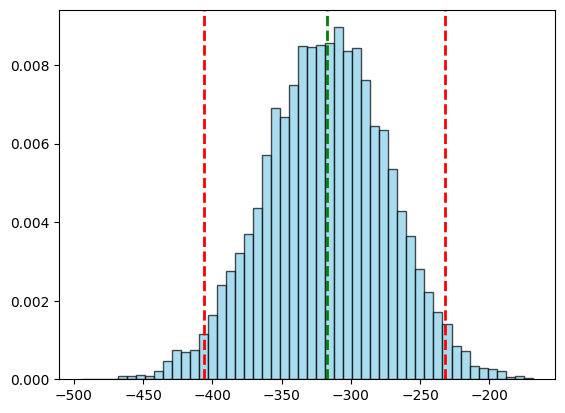

In [ ]:
lower_bound = float(np.percentile(bootstrap_mean_diffs, 2.5))
upper_bound = float(np.percentile(bootstrap_mean_diffs, 97.5))
mean_of_means_diff = np.mean(bootstrap_mean_diffs)
plt.hist(bootstrap_mean_diffs, bins=50, alpha=0.7, color='skyblue',
         edgecolor='black', density=True, label='Распределение разностей')
plt.axvline(x=lower_bound, color='red', linestyle='--', linewidth=2)
plt.axvline(x=upper_bound, color='red', linestyle='--', linewidth=2)
plt.axvline(x=mean_of_means_diff, color='green', linestyle='--', linewidth=2)
plt.show()

0 Находиться значительно правее доверительного интервала, что указывает на то, что значения действительно статистически различны, что дает весомое обоснование для отвержения нулевой гипотезы.

Бизнес-выводы

Гипотеза подтверждена: новые пользователи, которые проводят больше времени на товарных страницах, действительно чаще совершают покупки.
   

Бизнес-рекомендации:
  1. Улучшение интуитивности:
      - Упростить навигацию по товарным страницам
      - Добавить "хлебные крошки" и понятные фильтры
      - Улучшить мобильную версию для новых пользователей
   
  2. Удержание внимания:
      - Внедрить интерактивные элементы на товарных страницах
      - Добавить видеообзоры и 360° просмотр товаров
      - Реализовать "умные" рекомендации похожих товаров
   
  3. Аналитика и оптимизация:
      - Отслеживать среднее время на сайте для новых пользователей как KPI
      - A/B тестировать изменения в дизайне товарных страниц
      - Создать сегмент "новые пользователи с низким временем на сайте" для ремаркетинга
   
  4. Персонализация:
      - Для новых пользователей показывать упрощенный интерфейс
      - Добавить туториал по использованию каталога
      - Внедрить чат-бота для помощи в выборе товара